In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter

# Fix the file path to use proper escape characters
csv_path = r"graded_exams.csv"  # Using raw string to avoid escape sequence issues
df = pd.read_csv(csv_path)

# Ensure that we don't modify original data
df = df.copy()

In [2]:
# Features (excluding actual grade columns)
features = df.drop(columns=['math grade', 'reading grade', 'writing grade'])

# Target variables
target_math = df['math grade']
target_reading = df['reading grade']
target_writing = df['writing grade']

# Reset indices to avoid potential index mismatches
features.reset_index(drop=True, inplace=True)
target_math.reset_index(drop=True, inplace=True)
target_reading.reset_index(drop=True, inplace=True)
target_writing.reset_index(drop=True, inplace=True)

In [3]:
def split_data(features, target_math, target_reading, target_writing):
    # First split: Training (70%) and Temp (30%)
    X_train, X_temp, y_train_math, y_temp_math, y_train_reading, y_temp_reading, y_train_writing, y_temp_writing = train_test_split(
        features, target_math, target_reading, target_writing, test_size=0.3, random_state=42
    )

    # Second split: Testing (20%) and Unseen (10%) from Temp (30%)
    X_test, X_unseen, y_test_math, y_unseen_math, y_test_reading, y_unseen_reading, y_test_writing, y_unseen_writing = train_test_split(
        X_temp, y_temp_math, y_temp_reading, y_temp_writing, test_size=1/3, random_state=42
    )

    return (
        X_train, X_test, X_unseen,
        y_train_math, y_test_math, y_unseen_math,
        y_train_reading, y_test_reading, y_unseen_reading,
        y_train_writing, y_test_writing, y_unseen_writing
    )

# Apply split
X_train, X_test, X_unseen, y_train_math, y_test_math, y_unseen_math, y_train_reading, y_test_reading, y_unseen_reading, y_train_writing, y_test_writing, y_unseen_writing = split_data(features, target_math, target_reading, target_writing)

In [4]:
def analyze_feature_combinations(X_data, y_data, features_to_analyze, min_samples=10):
    """
    This function enhances a rule-based classifier by identifying common feature 
    combinations that lead to specific grade outcomes. It groups data based on the 
    selected features and determines the most frequently occurring grade for each 
    combination, forming structured decision rules for classification.

    Grouping by feature sets helps uncover patterns that strongly correlate with 
    specific grades. By associating these feature combinations with the most common 
    grade, the function builds a structured lookup table that aids in classification. 
    To ensure reliability, a minimum sample threshold is applied, preventing rare and 
    potentially misleading patterns from affecting decision-making. This improves the 
    consistency of the model and reduces noise in the classification process.

    The function is particularly useful in rule-based systems, as it generates 
    human-readable classification rules that are easy to interpret and apply. The 
    output is a dictionary that maps feature combinations to their most common grade, 
    along with a distribution of grades observed for that combination.
    """
    results = {}

    # Create a copy of X_data and add the target variable
    data = X_data.copy()
    data['grade'] = y_data  # Attach the target variable for analysis

    # Group dataset by the selected features
    grouped = data.groupby(features_to_analyze)

    for name, group in grouped:
        # Ensure only meaningful samples are considered
        if len(group) >= min_samples:
            # Count occurrences of each grade
            grade_counts = Counter(group['grade'])
            
            # Identify the most frequently occurring grade
            if grade_counts:
                most_common_grade = grade_counts.most_common(1)[0][0]
                
                # Store the results, ensuring consistency in key format
                if isinstance(name, tuple):
                    results[name] = (most_common_grade, grade_counts)
                else:
                    results[(name,)] = (most_common_grade, grade_counts)
    
    return results


In [5]:
class AdvancedRuleClassifier:
    def __init__(self, subject):
        self.subject = subject
        self.rules = []
        self.default_grade = None
        
    def build(self, X_train, y_train):
        """
        Build a hierarchy of rules based on the training data
        """
        # First level: Parental education + test prep
        education_test_prep_rules = analyze_feature_combinations(
            X_train, y_train, 
            ['parental level of education', 'test preparation course'],
            min_samples=10
        )
        
        # Second level: Parental education + test prep + gender
        education_test_prep_gender_rules = analyze_feature_combinations(
            X_train, y_train, 
            ['parental level of education', 'test preparation course', 'gender'],
            min_samples=8
        )
        
        # Third level: Parental education + test prep + lunch
        education_test_prep_lunch_rules = analyze_feature_combinations(
            X_train, y_train, 
            ['parental level of education', 'test preparation course', 'lunch'],
            min_samples=8
        )
        
        # Fourth level: Parental education + test prep + race/ethnicity
        education_test_prep_race_rules = analyze_feature_combinations(
            X_train, y_train, 
            ['parental level of education', 'test preparation course', 'race/ethnicity'],
            min_samples=5
        )
        
        # Store rules in order of specificity (most specific first)
        self.rules = [
            (education_test_prep_race_rules, ['parental level of education', 'test preparation course', 'race/ethnicity']),
            (education_test_prep_lunch_rules, ['parental level of education', 'test preparation course', 'lunch']),
            (education_test_prep_gender_rules, ['parental level of education', 'test preparation course', 'gender']),
            (education_test_prep_rules, ['parental level of education', 'test preparation course'])
        ]
        
    def predict(self, X):
        """
        Predict grades using the rule hierarchy
        """
        predictions = []
        
        for _, instance in X.iterrows():
            prediction = None
            
            # Try each rule level
            for rule_set, features in self.rules:
                if prediction:
                    break
                
                feature_values = tuple(instance[feature] for feature in features)
                
                if feature_values in rule_set:
                    prediction = rule_set[feature_values][0]
            
            # Use default grade if no rules match
            if not prediction:
                prediction = self.default_grade
                
            predictions.append(prediction)
        
        return predictions

In [6]:
# Train advanced rule-based classifiers for each subject
math_classifier = AdvancedRuleClassifier("Math")
math_classifier.build(X_train, y_train_math)

reading_classifier = AdvancedRuleClassifier("Reading")
reading_classifier.build(X_train, y_train_reading)

writing_classifier = AdvancedRuleClassifier("Writing")
writing_classifier.build(X_train, y_train_writing)

In [7]:
# Make predictions
y_pred_math = math_classifier.predict(X_test)
y_pred_reading = reading_classifier.predict(X_test)
y_pred_writing = writing_classifier.predict(X_test)

In [8]:
def evaluate_classifier(y_true, y_pred, subject):
    print(f"Evaluation for {subject}:")

    y_pred = pd.Series(y_pred).reset_index(drop=True)
    y_true = pd.Series(y_true).reset_index(drop=True)

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}\n")
    
    # Print classification report
    print(classification_report(y_true, y_pred, zero_division=0))

# Evaluate the classifiers
evaluate_classifier(y_test_math, y_pred_math, "Math")
evaluate_classifier(y_test_reading, y_pred_reading, "Reading")
evaluate_classifier(y_test_writing, y_pred_writing, "Writing")

Evaluation for Math:
Accuracy: 0.58

               precision    recall  f1-score   support

Above Average       0.00      0.00      0.00         7
      Average       0.00      0.00      0.00        13
Below Average       0.00      0.00      0.00        19
    Excellent       0.00      0.00      0.00         6
      Failure       0.62      0.97      0.75       121
         Good       0.00      0.00      0.00         9
      Passing       0.00      0.00      0.00        19
     Superior       0.00      0.00      0.00         6

     accuracy                           0.58       200
    macro avg       0.08      0.12      0.09       200
 weighted avg       0.37      0.58      0.46       200

Evaluation for Reading:
Accuracy: 0.47

               precision    recall  f1-score   support

Above Average       0.00      0.00      0.00        19
      Average       0.12      0.05      0.07        20
Below Average       0.00      0.00      0.00        19
    Excellent       0.33      0.17     

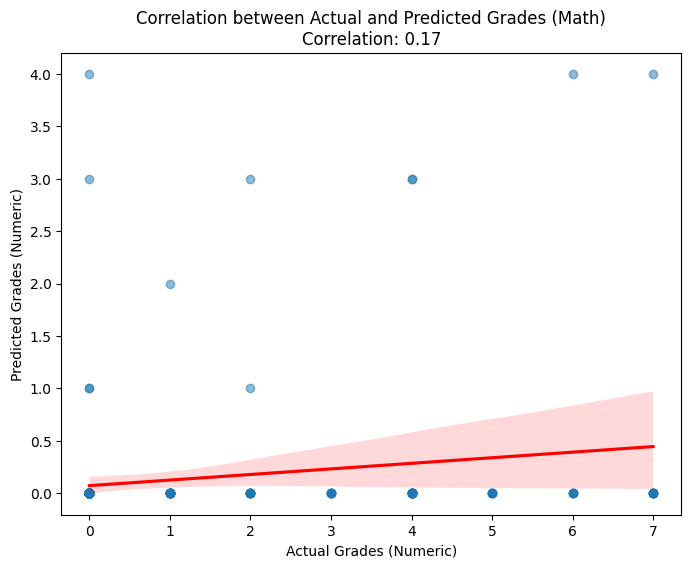

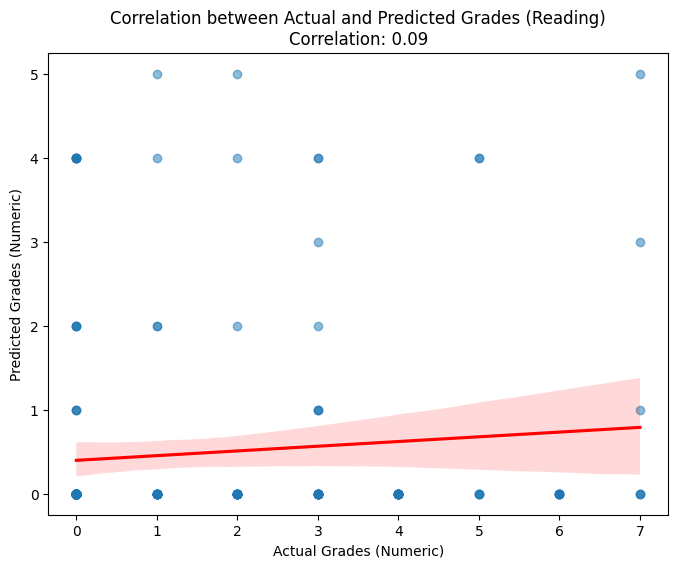

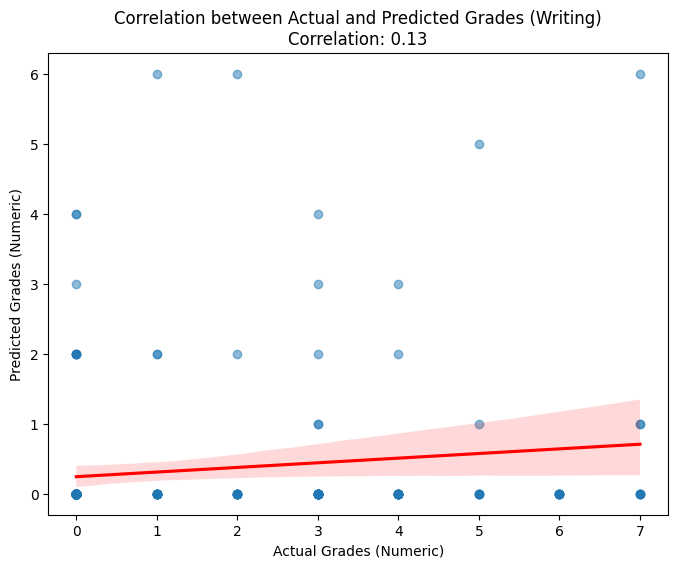

In [13]:
def plot_correlation(y_true, y_pred, subject):
    # Convert categorical grades to numeric values
    y_true_numeric = pd.factorize(pd.Series(y_true))[0]
    y_pred_numeric = pd.factorize(pd.Series(y_pred))[0]

    # Compute correlation
    correlation = np.corrcoef(y_true_numeric, y_pred_numeric)[0, 1]

    plt.figure(figsize=(8, 6))
    sns.regplot(x=y_true_numeric, y=y_pred_numeric, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    
    plt.xlabel("Actual Grades (Numeric)")
    plt.ylabel("Predicted Grades (Numeric)")
    plt.title(f"Correlation between Actual and Predicted Grades ({subject})\nCorrelation: {correlation:.2f}")
    plt.show()

# Example usage
plot_correlation(y_test_math, y_pred_math, "Math")
plot_correlation(y_test_reading, y_pred_reading, "Reading")
plot_correlation(y_test_writing, y_pred_writing, "Writing")


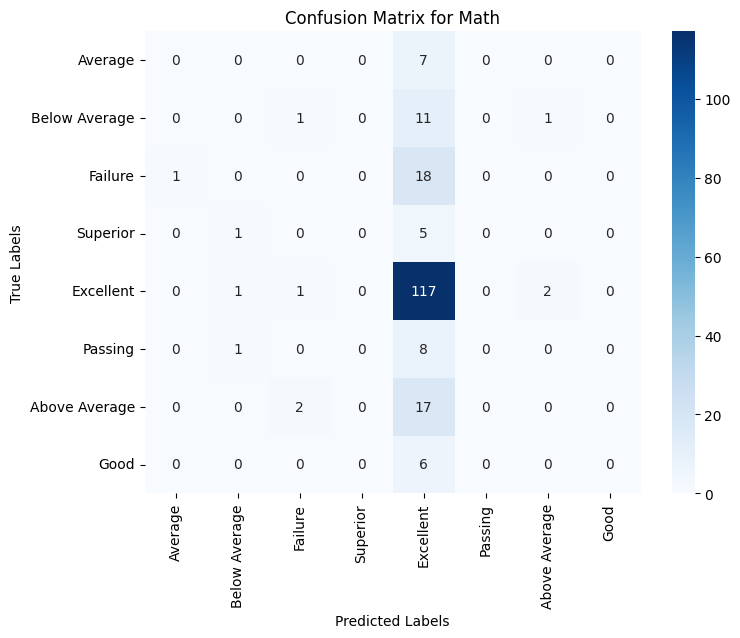

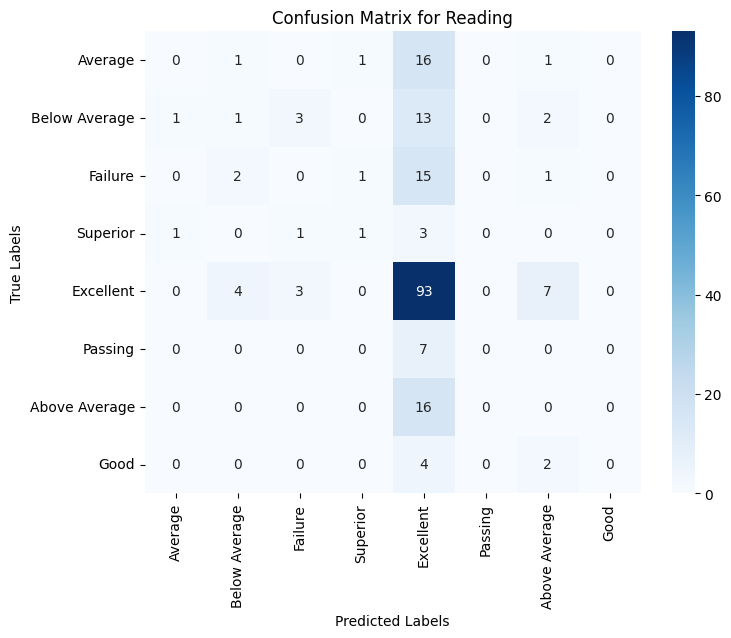

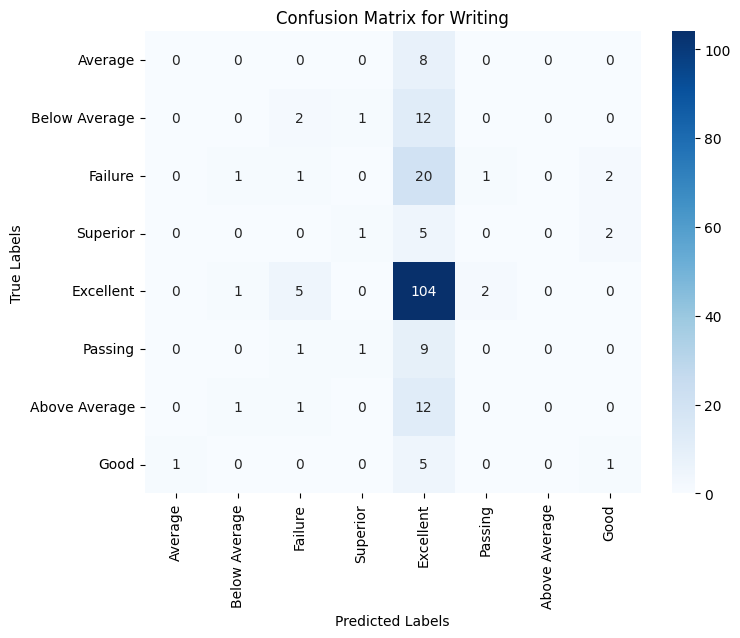

In [14]:
def plot_confusion_matrix(y_true, y_pred, subject):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_true), yticklabels=set(y_true))
    
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {subject}")
    plt.show()

# Confusion matrices for each subject
plot_confusion_matrix(y_test_math, y_pred_math, "Math")
plot_confusion_matrix(y_test_reading, y_pred_reading, "Reading")
plot_confusion_matrix(y_test_writing, y_pred_writing, "Writing")